## Importiere `pandas`, `matplotlib`

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import json
from datetime import datetime as dt
import locale
from scipy.interpolate import interp1d
from configparser import ConfigParser
from functions import *
from matplotlib.patches import Patch

## Lade die Konfigurationen aus `config.ini`
#### Definiere die Umgebung

In [15]:
config = ConfigParser()
files = config.read('config.ini')

# Wechsel des plt.style per config.ini machbar.
plt.style.use(config.get('theme', 'plt.style'))

# Damit Daten mit den deutschen Begriffen für die Monat generiert werden.
locale = locale.setlocale(locale.LC_TIME, "de_DE")

In [16]:
env = 'final'
database_file = config.get(env, 'database_file')
date_begin = config.get(env, 'date_begin')
date_end = config.get(env, 'date_end')
dpi = config.get(env, 'dpi')

target = ["covid", "ukraine"]

In [17]:
df = pd.read_json(database_file)

#### Filter die Artikel nach: Sind zwischen dem und dem Datum veröffentlich worden.

In [18]:
df = df.loc[(df['date'] >= date_begin) & (df['date'] <= date_end)]

In [19]:
df['date'] = pd.to_datetime(df['date'], utc=True)

#### Füge ein neues Feature hinzu: Themengebiet

In [20]:
topics = json.loads(open("topics/topics.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df['tags'].to_list()]

for topic in topics:
    df.loc[(df.title.str.contains('|'.join(topics[topic]['keywords'])) | df.tags_full.str.contains('|'.join(topics[topic]['keywords']))), 'topic'] = topics[topic]['name']

#### Füge vier neue Features hinzu: Tag, Woche, Monat, Jahr

In [21]:
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

#### Füge zwei neue Features hinzu: Anzahl Wörter, Anzahl Zeichen

In [22]:
df['content_length'] = df['content'].str.len()
df['content_words'] = df['content'].str.split().map(len)

## Gruppiere die Artikel nach: Woche (eindeutig)

In [23]:
target_names = list(map(lambda short: topics[short]['name'], target))

def perform_group(df: pd.DataFrame, column: str):
    return df.groupby(["week", "year"])['content_words'].mean().reset_index(name=column)

df = merge_data_week_year2(df, from_column='topic', to_columns=target_names, perform_group=perform_group)

#### Fülle die leeren Felder mit der Anzahl 0

In [24]:
df = df.fillna(0)

In [25]:
df = df.sort_values('timestamp', ascending=True)

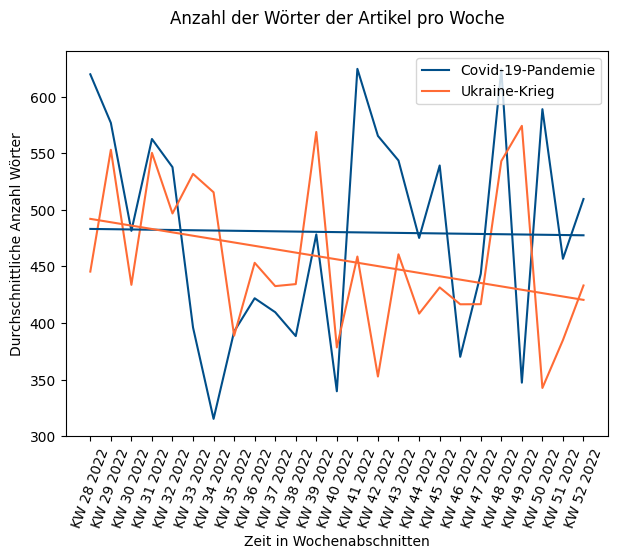

In [27]:
color = ["#004e89", "#ff6b35", "#f7c59f", "#1a659e"]

ax = df.plot(kind="line", x="timestamp", y=target_names, color=color, rot=70, xlabel="Zeit in Wochenabschnitten", figsize=(7,5), ylabel="Durchschnittliche Anzahl Wörter")

ax.set_xticks(df.timestamp.to_list())
ax.set_xticklabels(df.date)

plot_trendlines(df, on_axis=ax, ucolumn="timestamp", colors=color, columns=target_names)

ax.set_title(f'Anzahl der Wörter der Artikel pro Woche', pad=20)

ax.get_figure().savefig(f'figures/line-trend-thema-länge/{("-".join(target))}.png', bbox_inches="tight", dpi=float(dpi))